#  Transfer Learning Sentiment Analysis
This notebook performs **Sentiment Analysis** using both a baseline LSTM with GloVe embeddings and fine-tuning **DistilBERT**.
Dataset: [Sentiment140 Kaggle Dataset](https://www.kaggle.com/datasets/kazanova/sentiment140).

In [ ]:

# Install dependencies
!pip install -q transformers datasets scikit-learn tensorflow wordcloud seaborn kagglehub


In [ ]:

import os, random, re
import numpy as np, pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Libraries loaded successfully")


✅ Libraries loaded successfully


##  Load Sentiment140 Dataset

In [ ]:

import kagglehub
path = kagglehub.dataset_download('kazanova/sentiment140')
print('Dataset path:', path)
DATA_FILE = os.path.join(path, 'training.1600000.processed.noemoticon.csv')
df = pd.read_csv(DATA_FILE, encoding='latin-1', header=None)
df.columns = ['label','id','date','query','user','text']
df = df[['label','text']]
print("Total rows:", len(df))
df['label'] = df['label'].map({0:0,4:1})
df = df[df['label'].isin([0,1])]
print(df['label'].value_counts())


Using Colab cache for faster access to the 'sentiment140' dataset.
Dataset path: /kaggle/input/sentiment140
Total rows: 1600000
label
0    800000
1    800000
Name: count, dtype: int64


##  Basic Cleaning & EDA

In [ ]:

nltk.download('stopwords', quiet=True)
stops = set(stopwords.words('english'))

def basic_clean(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^A-Za-z0-9\s']", " ", text)
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text

df['clean_text'] = df['text'].apply(basic_clean)

print("Sample tweets:")
for t in df['clean_text'].sample(5, random_state=SEED):
    print("-", t)


Sample tweets:
- ahhh i hope your ok
- cool i have no tweet apps for my razr 2
- i know just family drama its lame hey next time u hang out with kim n u guys like have a sleepover or whatever ill call u
- school email won't open and i have geography stuff on there to revise stupid school '
- upper airways problem


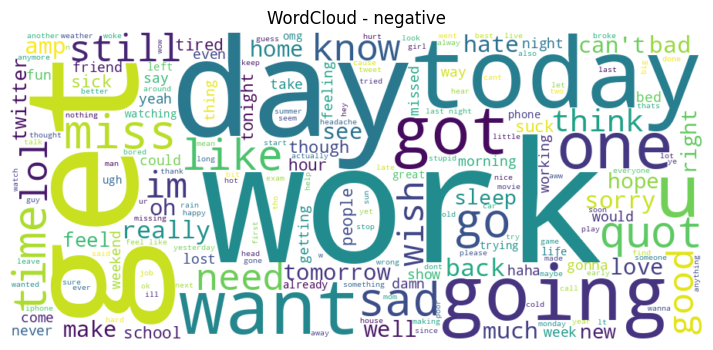

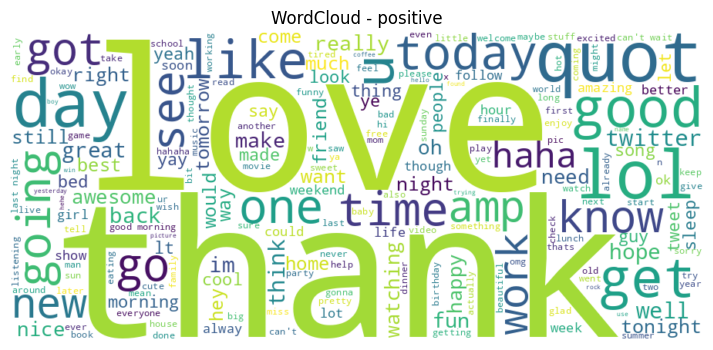

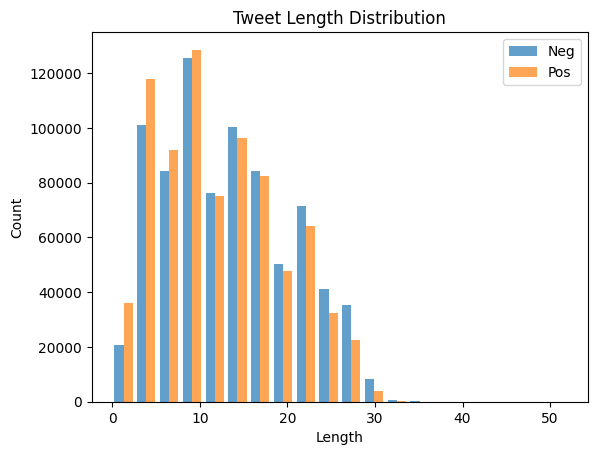

In [ ]:

# WordClouds
for lab, name in [(0,'negative'),(1,'positive')]:
    txt = " ".join(df[df['label']==lab]['clean_text'].sample(20000, random_state=SEED))
    wc = WordCloud(width=900, height=400, background_color='white', stopwords=stops).generate(txt)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {name}")
    plt.show()

# Tweet length distribution
df['len'] = df['clean_text'].apply(lambda x: len(x.split()))
plt.hist([df[df['label']==0]['len'], df[df['label']==1]['len']], bins=20, label=['Neg','Pos'], alpha=0.7)
plt.legend(); plt.xlabel("Length"); plt.ylabel("Count"); plt.title("Tweet Length Distribution")
plt.show()


##  Train / Validation / Test Split

In [ ]:

train_df, test_df = train_test_split(df, test_size=0.10, stratify=df['label'], random_state=SEED)
train_df, val_df = train_test_split(train_df, test_size=0.1111, stratify=train_df['label'], random_state=SEED)
print("Train/Val/Test sizes:", len(train_df), len(val_df), len(test_df))


Train/Val/Test sizes: 1280016 159984 160000


##  DistilBERT Fine-Tuning (Transfer Learning)

In [ ]:
def distilbert(train_df, val_df, test_df):
    from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
    from datasets import Dataset

    print("\n== DistilBERT fine-tune ==")
    model_name = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

  # CONVERT PANDAS DATAFRAME INTO HF DATASET
    def df_to_dataset(df):
        return Dataset.from_pandas(df[['text','label']]) # Convert to HuggingFace dataset

    train_dataset = df_to_dataset(train_df)
    val_dataset = df_to_dataset(val_df)
    test_dataset = df_to_dataset(test_df)

    # TOKENIZATION: TURN TEXT INTO MODEL-READY INPUTS
    def preprocess(examples):
        return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

    # Apply tokenizer to all datasets
    train_dataset = train_dataset.map(preprocess, batched=True)
    val_dataset = val_dataset.map(preprocess, batched=True)
    test_dataset = test_dataset.map(preprocess, batched=True)

    # SET DATASET FORMAT FOR TENSORFLOW
    train_dataset.set_format(type='tensorflow', columns=['input_ids','attention_mask','label'])
    val_dataset.set_format(type='tensorflow', columns=['input_ids','attention_mask','label'])
    test_dataset.set_format(type='tensorflow', columns=['input_ids','attention_mask','label'])

    # Collator pads dynamically per batch (better efficiency)
    collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

    # Convert HF dataset into TF-friendly pipeline
    tf_train = train_dataset.to_tf_dataset(columns=['input_ids','attention_mask'], label_cols=['label'],
                                           shuffle=True, batch_size=32, collate_fn=collator)
    tf_val = val_dataset.to_tf_dataset(columns=['input_ids','attention_mask'], label_cols=['label'],
                                       shuffle=False, batch_size=32, collate_fn=collator)
    tf_test = test_dataset.to_tf_dataset(columns=['input_ids','attention_mask'], label_cols=['label'],
                                         shuffle=False, batch_size=32, collate_fn=collator)

    # LOAD DISTILBERT MODEL FOR CLASSIFICATION
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, use_safetensors=False)
    # Set optimizer, loss & evaluation metrics
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = [tf.metrics.SparseCategoricalAccuracy()]
    # Compile model to make it trainable
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()

    # TRAIN THE MODEL
    history = model.fit(tf_train, validation_data=tf_val, epochs=1)

    # PREDICTION ON TEST SET
    preds = model.predict(tf_test).logits
    y_pred = np.argmax(preds, axis=1)
    y_true = np.array(test_df["label"])

    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=['negative','positive']))

     # CONFUSION MATRIX FOR VISUAL PERFORMANCE CHECK
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg','Pos'], yticklabels=['Neg','Pos'])
    plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

     # SAVE MODEL
    model.save_pretrained("./distilbert_sentiment_model")
    tokenizer.save_pretrained("./distilbert_sentiment_model")
    print(" Model saved to ./distilbert_sentiment_model")

    return model, tokenizer



== DistilBERT fine-tune ==


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1280016 [00:00<?, ? examples/s]

Map:   0%|          | 0/159984 [00:00<?, ? examples/s]

Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


tf_model.h5:   0%|          | 0.00/363M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
5000/5000 [==============================] - 6

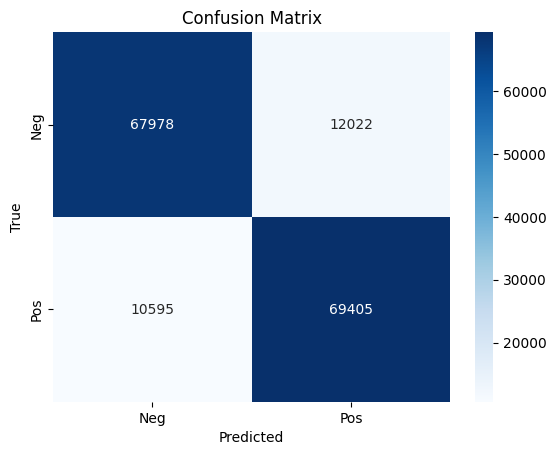

✅ Model saved to ./distilbert_sentiment_model


In [ ]:
#Execute the DistilBERT fine-tuning function
model, tokenizer = distilbert(train_df, val_df, test_df)

##  Inference Example

In [ ]:
import os
from transformers import (
    pipeline,
    DistilBertTokenizer,
    TFDistilBertForSequenceClassification,
    AutoConfig
)

# Force offline mode so nothing is downloaded
os.environ["HF_HUB_OFFLINE"] = "1"

# Local model directory
local_model_dir_name = "distilbert_sentiment_model"
local_model_path = os.path.join(os.getcwd(), local_model_dir_name)

# Load tokenizer and config from local directory
tokenizer = DistilBertTokenizer.from_pretrained(local_model_path)
config = AutoConfig.from_pretrained(local_model_path)

# Load the TensorFlow model (remove from_tf=True)
model = TFDistilBertForSequenceClassification.from_pretrained(
    local_model_path,
    config=config
)

# Build pipeline
sentiment = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer
)

# Test examples
examples = [
    "I absolutely love this!",
    "This is the worst experience ever."
]

for text in examples:
    print(text, "->", sentiment(text)[0])


Some layers from the model checkpoint at /content/distilbert_sentiment_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/distilbert_sentiment_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
TensorFlow and JAX classes are depre

I absolutely love this! -> {'label': 'LABEL_1', 'score': 0.9879420399665833}
This is the worst experience ever. -> {'label': 'LABEL_0', 'score': 0.9881104230880737}
